# VQC Model for classifiaction of toy dtastes, applying the Quantum SafeML Method
In this notebook, we instantiate a Variational Quantum classifier using Qiskit, and fit it to a number of different datasets, then evaluatiing the perfoamnce of the models on each class in the dataset using the Quantum SafeMl Method of computing the distance metric values between correctly and incorrectly classified targets. This notebook was inttially based on the qiskit machien learning notebook [For trainign a quantum model on a real dataset](https://github.com/qiskit-community/qiskit-machine-learning/blob/stable/0.8/docs/tutorials/02a_training_a_quantum_model_on_a_real_dataset.ipynb)

## Importing necessary libraries
We begin by importing all required libraries for this excercise. This includes various tools using qiskit, the IBM quanutm computing library. From here we can import many attrbiutes that will form the Quantum hybrid mdoel that will be cosntructed later.
We also make sure to impriot libraries for lienar algebra in order to fully comptue the distance emtrics used later in the Quantum SafeML method appliction.
We also make sure to include libraries such as MinMax Scaler and trian test split for data preprocessing.

In [11]:
#import necessary librarires
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals
import numpy as np
from scipy.linalg import sqrtm, logm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import Bunch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
from tabulate import tabulate

## Defining functiosn for data Conversion And Distance Metrics
The Quantum SafeML Method wirks usign quantum statistical distance measures. The 4 implemented ehre are trace distance, bures distance, fidelity, and Quanutm relative Entropy. these are converted into python fucntions using linear algebra libraries where appropriate. Each of these metrics require density matrix inputs, and so a fucntion is constructed for converting numpy arrays, a standard model output type, into density matrices.

In [12]:
# A method for converting data into density matrix format
def create_density_matrix(data):
    """Convert feature vectors into a density matrix."""
    if data.shape[0] < 2:  # Check if there's at least 2 samples
        print("Warning: Not enough data points to compute covariance. Returning identity matrix.")
        return np.eye(data.shape[1])  # Return identity matrix of appropriate size

    cov_matrix = np.cov(data, rowvar=False)  # Covariance matrix
    trace = np.trace(cov_matrix)
    
    if trace == 0:  # Avoid division by zero
        print("Warning: Trace is zero. Returning identity matrix.")
        return np.eye(data.shape[1])

    density_matrix = cov_matrix / trace  # Normalize trace to 1
    return density_matrix

#implemented bures distance metric function
def bures_distance(rho1, rho2):
    """Compute the Bures distance between two density matrices."""
    if rho1.shape != rho2.shape:
        raise ValueError("The two density matrices must have the same shape.")

    # Ensure matrices are Hermitian (conjugate transpose equals the matrix)
    rho1 = np.array(rho1, dtype=complex)
    rho2 = np.array(rho2, dtype=complex)
    
    sqrt_rho1 = sqrtm(rho1 + 1e-10 * np.eye(rho1.shape[0]))  # Add small noise for stability
    intermediate = sqrt_rho1 @ rho2 @ sqrt_rho1
    sqrt_intermediate = sqrtm(intermediate)
    fidelity_value = np.real(np.trace(sqrt_intermediate)) ** 2
    bures_dist = np.sqrt(2 * (1 - np.sqrt(fidelity_value)))
    
    return bures_dist

#implemented fidelity metric function
def fidelity(rho1, rho2):
    """Compute the fidelity between two density matrices."""
    if rho1.shape != rho2.shape:
        raise ValueError("The two density matrices must have the same shape.")

    # Ensure matrices are Hermitian (conjugate transpose equals the matrix)
    rho1 = np.array(rho1, dtype=complex)
    rho2 = np.array(rho2, dtype=complex)
    
    sqrt_rho1 = sqrtm(rho1)
    sqrt_rho2 = sqrtm(rho2)
    fidelity_value = np.real(np.trace(sqrt_rho1 @ sqrt_rho2))**2

    return fidelity_value

#implemented trace distance metric function
def trace_distance(rho1, rho2):
    """Compute the trace distance between two density matrices."""
    if rho1.shape != rho2.shape:
        raise ValueError("The two density matrices must have the same shape.")

    # Ensure matrices are Hermitian (conjugate transpose equals the matrix)
    rho1 = np.array(rho1, dtype=complex)
    rho2 = np.array(rho2, dtype=complex)

    trace_dist = 0.5 * np.trace(np.abs(rho1 - rho2))
    
    return trace_dist

#implemented quantum relative entropy metric function
def quantum_relative_entropy(rho1, rho2):
    """Compute the quantum relative entropy between two density matrices."""
    if rho1.shape != rho2.shape:
        raise ValueError("The two density matrices must have the same shape.")

    # Ensure the matrices are positive semidefinite and well-conditioned
    if np.any(np.linalg.eigvals(rho1) < 0) or np.any(np.linalg.eigvals(rho2) < 0):
       # raise ValueError("The input density matrices must be positive semidefinite.")
        return 1
        
    # Calculate the logarithms of the density matrices
    log_rho1 = logm(rho1)
    log_rho2 = logm(rho2)

    relative_entropy = np.trace(rho1 @ (log_rho1 - log_rho2))

    return relative_entropy

## Custom Dataset production for research augmentation
In this experiemnt, we examine the implemented VQC model's performance and the Results fo the distance emasures on this using the toy datasets from sklearn, iris and wine. Whilst these 2 datasets are cosnistent within eachother and will be applicable to this mdoel cenario, the findings will benefit from auxhillary datasets of the same nature. 

For this, we create a function, capable of takinga  set of classes and featrues, and an amount of samples, and using these to structure a bunch dataset with a simialr layout to that found in the toy datasets. This is then populated with synthesized data in a unifrom distribtuion. 

Whilst this dtaaset will be inherently random and will not represent any real world information, it will allow for further trainign and analysis of the model architecture.

In [13]:
#function for geenrating custom bunch dataset with synthetic randomly generated data.
def generate_custom_dataset(class_labels, feature_names, num_samples=200):
    np.random.seed(42)  # For reproducibility

    # Generate random numerical data for each feature
    features = []
    for _ in feature_names:
        features.append(np.random.uniform(0, 10, num_samples))  # Random values between 0-10

    # Stack features into a NumPy array
    feature_matrix = np.column_stack(features)

    # Assign random class labels
    labels = np.random.choice(class_labels, num_samples)

    # Encode labels as numbers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Normalize feature values
    scaler = MinMaxScaler()
    normalized_features = scaler.fit_transform(feature_matrix)

    # Return dataset in a Bunch object
    return Bunch(
        data=normalized_features,
        target=encoded_labels,
        target_names=np.array(class_labels),
        feature_names=feature_names
    )

# Print a description of the dataset, similar to what sklearn does for its datasets.
def print_dataset_description(dataset):
    print("Dataset description:")
    print(f"Number of samples: {dataset.data.shape[0]}")
    print(f"Number of features: {dataset.data.shape[1]}")
    print(f"Feature names: {', '.join(dataset.feature_names)}")
    print(f"Classes: {', '.join(dataset.target_names)}")
    print("\nFirst 5 samples:")
    print(pd.DataFrame(dataset.data, columns=dataset.feature_names).head())  # First 5 rows of features
    print("\nFirst 5 target labels:")
    print(dataset.target[:5])  # First 5 labels

## Instantiating the VQC Architecture
We now move to implementening the VQC itself, definign he exact structure for our model. 

In this Experiment, we make this a reusable function, for future deployment as well as ensuring that in this runthrough, it can be made comptaible with the range of shapes we expect from our different datasets.

This entails a function which takes the respective features and labels of  a dataset for caluclation. Additionalyl here, we specify a default target class, that will eb used in application of the Quantum SafeML Method for comparison ebtween correct and incorrect predictions.

### Definign the feature map
The feature map is the way we encode classical data into quantum state, mapping the featrues directly to qubits, thereby defining the dimensionality of the model.

### Creating ansatz
ansatz refers tot he paramaterized quantum circuit our quantum encoded data will be passed to. We define it here in the model, specifying the number of qubits to match number of features.

### Specifying optimization algorithm
Here, we specify which optimisation algorithmour model will use to assess performance through iterations. Whilsta  range of optimizers are available for this, we choose COBYLA here for simplicity.

### Directing model to a simulator
Next, we must define the quantum architecture our model will train on. Of course, real quantum ahrdware is not yet readily avialble, but luckily there exists built in ways of emulating it, the one used here being qiskit's sampler.

### Data Preprocessing
Now that the paramters of oru model have been defined, we move to preprocessign the data in preperation for model fitting. This is a standard procedure for even classical ML models, and must still eb doen even to quantum encoded datasets.

### Constrcution of the classifier
The classifer is isnatnitated using our defiend attribtues, and this is then fitted tot he training data.

### preparing outputs for Safety analysis
Upon compeltion of model fittigns and predictions, two different sets are made. These are sets for correctly predicted datapoits for a given taregt class, and icnrrect predictiosn for this same class. these are converted to the matrix format, and returned by the model function alongside an accuracy score.


In [14]:
# Modify the callback function to accept objective_func_vals as an argument
def callback_graph(weights, obj_func_eval, objective_func_vals):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return objective_func_vals  # Return the updated list

def makeVQC(features, labels, target_class = 1):
    #define feature map
    num_features = features.shape[1]

    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    feature_map.decompose().draw(output="mpl", style="clifford", fold=0)

    # create ansatz
    from qiskit.circuit.library import RealAmplitudes

    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    ansatz.decompose().draw(output="mpl", style="clifford", fold=0)

    #optimization algorithm
    optimizer = COBYLA(maxiter=100)

    #provide sampler
    sampler = Sampler()

    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)


    algorithm_globals.random_seed = 123
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
    )

    #construct classifier
    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=lambda weights, obj_func_eval: callback_graph(weights, obj_func_eval, objective_func_vals),
    )

    # clear objective value history
    objective_func_vals = []

    start = time.time()
    vqc.fit(train_features, train_labels)
    elapsed = time.time() - start

    print(f"Training time: {round(elapsed)} seconds")

    # Example arrays (replace these with your actual arrays)
    predictions = np.array(vqc.predict(test_features))  # Predicted labels
    actual_labels = np.array(test_labels)  # True labels

    # Get misclassified data points where the prediction is target_class but the actual label is different
    misclassified_as_target = test_features[(predictions == target_class) & (actual_labels != target_class)]

    # Get correctly classified data points where the actual label is target_class
    correctly_classified_as_target = test_features[(actual_labels == target_class)]

    #print("Misclassified as target:", misclassified_as_target)
    #print("Correctly classified as target:", correctly_classified_as_target)

    # Convert to density matrices
    rho1 = create_density_matrix(misclassified_as_target)
    rho2 = create_density_matrix(correctly_classified_as_target)

    # Ensure same shape (truncate to smaller size)
    min_dim = min(rho1.shape[0], rho2.shape[0])
    rho1 = rho1[:min_dim, :min_dim]
    rho2 = rho2[:min_dim, :min_dim]
    accuracy = vqc.score(test_features, test_labels)
    
    return rho1, rho2, accuracy
    

## Synthesis of data
Employing our previously defiend custom dataset generation fucntion, we now build two sampel datasets for fitting to VQC models.

In [15]:
family_class_labels = ["peter", "stewie", "brian"]
family_feature_names = ["Love for lois", "Cutaway gag frequency", "Fights with chicken", "positivity of makign you laugh and cry"]
family_num_samples = 200

family_data = generate_custom_dataset(family_class_labels, family_feature_names, family_num_samples)

transport_class_labels = ["Bus", "Car", "Bike", "Walk"]
transport_feature_names = ["Distance from Home", "Traffic Intensity", "Time of Day", "Route Simplicity", "Cost"]
transport_num_samples = 320

transport_data = generate_custom_dataset(transport_class_labels, transport_feature_names, transport_num_samples)

## Importing of existing toy datasets
the sklearn toy dataset serve as good benchmarks for machine learning problems due tot heir simplicty and versatility. here, we import the iris and wine datasets respectively for fitting to our VQC models.

In [16]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine

iris_data = load_iris()
wine_data = load_wine()

iris_features, iris_labels = iris_data.data, iris_data.target
wine_features, wine_labels = wine_data.data, wine_data.target
family_features, family_labels = family_data.data, family_data.target
transport_features, transport_labels = transport_data.data, transport_data.target

iris_features = MinMaxScaler().fit_transform(iris_features)
wine_features = MinMaxScaler().fit_transform(wine_features)
family_features = MinMaxScaler().fit_transform(family_features)
transport_features = MinMaxScaler().fit_transform(transport_features)

## fitting VQCs to our datasets
We call our make_VQC function onto each dataset, storign the outputs into 2 density matrices each for later comparison.

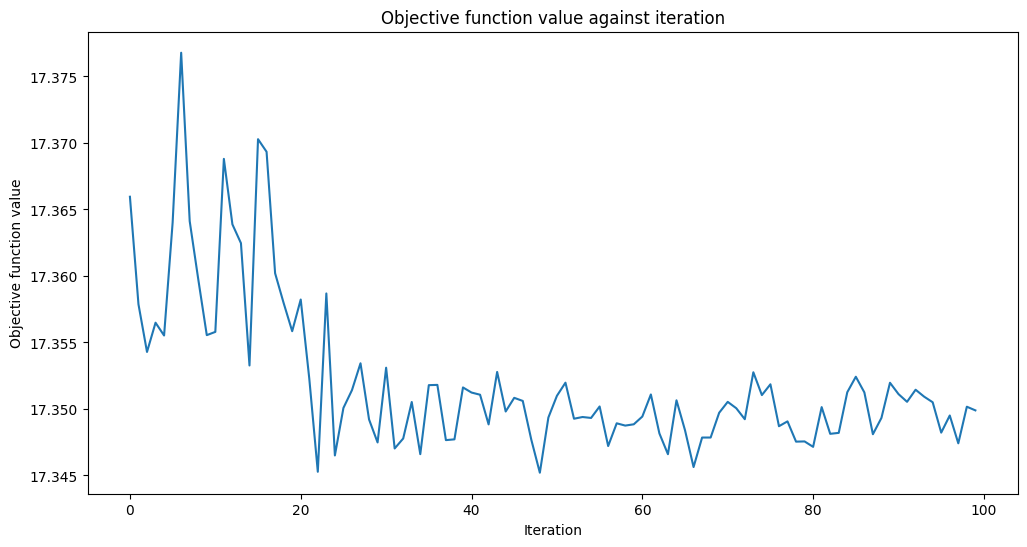

Training time: 253 seconds


In [17]:
iris_rho1, iris_rho2, iris_accuracy = makeVQC(iris_features, iris_labels)
wine_rho1, wine_rho2, wine_accuracy = makeVQC(wine_features, wine_labels)
family_rho1, family_rho2, family_accuracy = makeVQC(family_features, family_labels)
transport_rho1, transport_rho2, transport_accuracy = makeVQC(transport_features, transport_labels)

## Viewing Metric results
Once our results have been extarcted, we visualise a table shwoign their resutls across all datastes for the chosen analysis class

In [18]:
# Create the DataFrame
data = {
    "Dataset": ["Iris", "Wine", "Family", "Transport"],
    "Bures Distance": [
        bures_distance(iris_rho1, iris_rho2),
        bures_distance(wine_rho1, wine_rho2),
        bures_distance(family_rho1, family_rho2),
        bures_distance(transport_rho1, transport_rho2),
    ],
    "Trace Distance": [
        trace_distance(iris_rho1, iris_rho2),
        trace_distance(wine_rho1, wine_rho2),
        trace_distance(family_rho1, family_rho2),
        trace_distance(transport_rho1, transport_rho2),
    ],
    "Fidelity": [
        fidelity(iris_rho1, iris_rho2),
        fidelity(wine_rho1, wine_rho2),
        fidelity(family_rho1, family_rho2),
        fidelity(transport_rho1, transport_rho2),
    ],
    "Quantum Relative Entropy": [
        #quantum_relative_entropy(iris_rho1, iris_rho2),
        #quantum_relative_entropy(wine_rho1, wine_rho2),
        1,1,
        quantum_relative_entropy(family_rho1, family_rho2),
        quantum_relative_entropy(transport_rho1, transport_rho2),
    ],
    "True Accuracy": [iris_accuracy, wine_accuracy, family_accuracy, transport_accuracy],
}

df = pd.DataFrame(data)

# Print the table with a stylish format
print(tabulate(df, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))



╒════╤═══════════╤══════════════════╤══════════════════╤════════════╤════════════════════════════╤═════════════════╕
│    │ Dataset   │   Bures Distance │   Trace Distance │   Fidelity │   Quantum Relative Entropy │   True Accuracy │
╞════╪═══════════╪══════════════════╪══════════════════╪════════════╪════════════════════════════╪═════════════════╡
│  0 │ Iris      │           0.7695 │           0.5208 │     0.4347 │                     1.0000 │          0.5667 │
├────┼───────────┼──────────────────┼──────────────────┼────────────┼────────────────────────────┼─────────────────┤
│  1 │ Wine      │           0.8832 │           0.3467 │     0.2982 │                     1.0000 │          0.3056 │
├────┼───────────┼──────────────────┼──────────────────┼────────────┼────────────────────────────┼─────────────────┤
│  2 │ Family    │           0.3021 │           0.0710 │     0.9098 │                     0.1810 │          0.3000 │
├────┼───────────┼──────────────────┼──────────────────┼────────

## Comparing raw metric valeus across datasets
the metric overall values across the chosen class of the different datasets is now visualised.

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


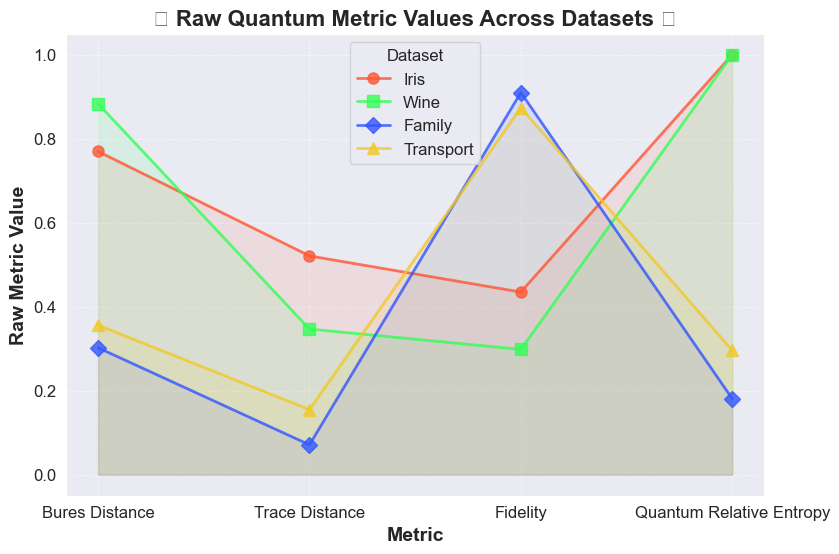

In [19]:
# Use a cool Seaborn style
sns.set_style("darkgrid")
plt.rcParams.update({"font.size": 12, "axes.labelweight": "bold"})  # Better fonts

# Data
datasets = ["Iris", "Wine", "Family", "Transport"]
metrics = ["Bures Distance", "Trace Distance", "Fidelity", "Quantum Relative Entropy"]

# Metric values
metric_values = {dataset: df.loc[df["Dataset"] == dataset, metrics].values.flatten() for dataset in datasets}

# Define colors and markers
colors = ["#ff5733", "#33ff57", "#3357ff", "#f0c929"]
markers = ["o", "s", "D", "^"]

# Create figure
plt.figure(figsize=(9, 6))

# Plot each dataset's raw metric values with stylish tweaks
for i, dataset in enumerate(datasets):
    plt.plot(metrics, metric_values[dataset], marker=markers[i], linestyle='-', 
             color=colors[i], markersize=8, alpha=0.8, linewidth=2, label=dataset)
    
    # Fill under each dataset's line for effect
    plt.fill_between(metrics, metric_values[dataset], alpha=0.1, color=colors[i])

# Formatting
plt.xlabel("Metric", fontsize=14, fontweight="bold")
plt.ylabel("Raw Metric Value", fontsize=14, fontweight="bold")
plt.title("🔥 Raw Quantum Metric Values Across Datasets 🔥", fontsize=16, fontweight="bold")
plt.legend(title="Dataset", fontsize=12)
plt.grid(True, linestyle="dashed", alpha=0.5)

# Show plot
plt.show()


## Comparing metric values across datasets in closeness to accuracy
the metric values are now assessed to their direct proximity to the models accuracy score. Tjis will give a better idea of how the metrics are performing in line with the mmodel performance.

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


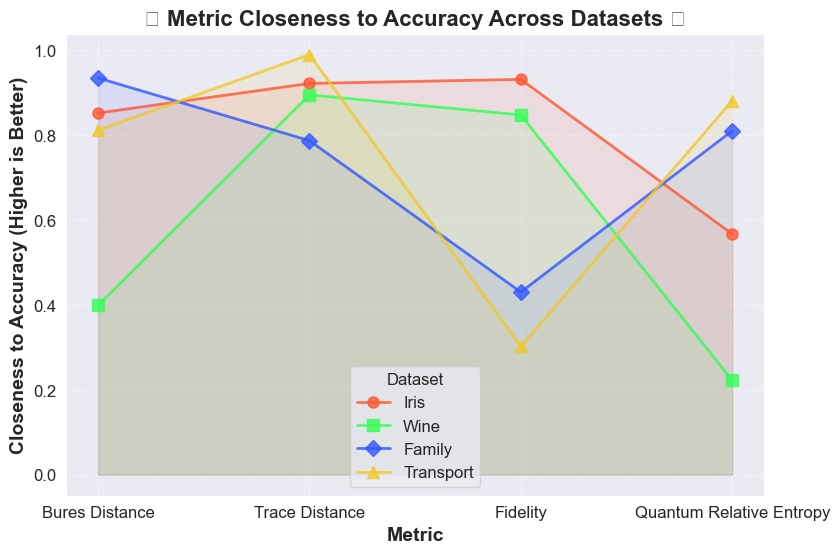

In [54]:
#Use a cool Seaborn style
sns.set_style("darkgrid")
plt.rcParams.update({"font.size": 12, "axes.labelweight": "bold"})  # Better fonts

# Extract dataset names and metric names from the DataFrame
 

# Extract metric values from the DataFrame
metric_values = {dataset: df.loc[df["Dataset"] == dataset, metrics].values.flatten() for dataset in datasets}

# Extract accuracy values from the DataFrame
accuracy_scores = {dataset: df.loc[df["Dataset"] == dataset, "True Accuracy"].values[0] for dataset in datasets}

# Compute closeness to accuracy
closeness_values = {
    dataset: [1 - abs(metric_values[dataset][i] - accuracy_scores[dataset]) for i in range(len(metrics))]
    for dataset in datasets
}

# Define colors and markers
colors = ["#ff5733", "#33ff57", "#3357ff", "#f0c929"]
markers = ["o", "s", "D", "^"]

# Create figure
plt.figure(figsize=(9, 6))

# Plot each dataset's closeness values with stylish tweaks
for i, dataset in enumerate(datasets):
    plt.plot(metrics, closeness_values[dataset], marker=markers[i], linestyle='-', 
             color=colors[i], markersize=8, alpha=0.8, linewidth=2, label=dataset)
    
    # Fill under each dataset's line for effect
    plt.fill_between(metrics, closeness_values[dataset], alpha=0.1, color=colors[i])

# Formatting
plt.xlabel("Metric", fontsize=14, fontweight="bold")
plt.ylabel("Closeness to Accuracy (Higher is Better)", fontsize=14, fontweight="bold")
plt.title("🔥 Metric Closeness to Accuracy Across Datasets 🔥", fontsize=16, fontweight="bold")
plt.legend(title="Dataset", fontsize=12)
plt.grid(True, linestyle="dashed", alpha=0.5)

# Show plot
plt.show()


## Heatmap of metric accruacy proximity
Fianlly, We view the metrics score on the class for each datasets in a  heatmap showign its closenss to individual model accuracy score.

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


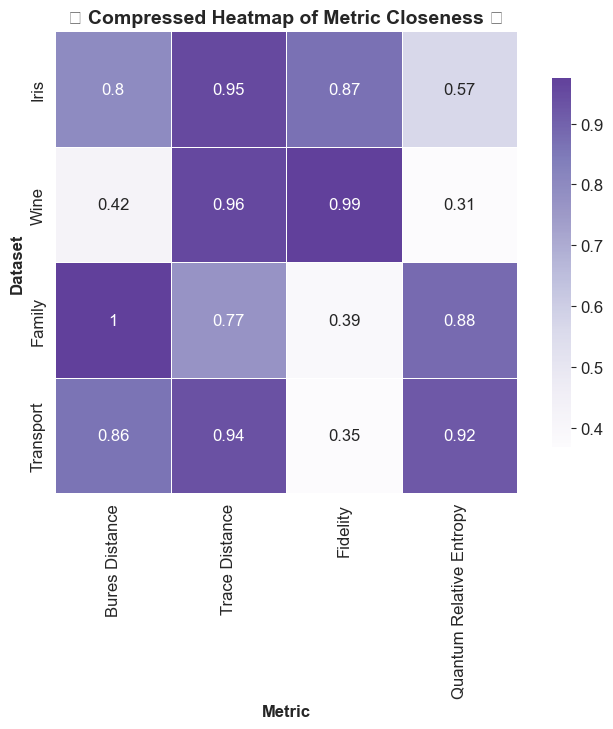

In [20]:
# Extract metric names (excluding 'Dataset' and 'True Accuracy')
metrics = df.columns[1:-1]

# Compute closeness to accuracy
closeness_values = df[metrics].apply(lambda col: 1 - abs(col - df["True Accuracy"]), axis=0)

# Compute tighter vmin and vmax using percentiles to remove extreme contrast
vmin = np.percentile(closeness_values, 10)  # 10th percentile (avoid extreme low values)
vmax = np.percentile(closeness_values, 90)  # 90th percentile (avoid extreme high values)

# Create heatmap with adjusted color scaling
plt.figure(figsize=(9, 6))
sns.heatmap(
    closeness_values, 
    annot=True, 
    cmap="Purples",  # Mid-range colormap (prevents extreme contrast)
    xticklabels=metrics, 
    yticklabels=df["Dataset"], 
    linewidths=0.5,  # Subtle grid lines
    square=True, 
    cbar=True, 
    cbar_kws={"shrink": 0.8},  # Compact color bar
    vmin=vmin,  # Restrict color scaling to reduce drastic differences
    vmax=vmax, 
    center=closeness_values.mean().mean()  # Shift color midpoint to balance colors
)

# Formatting
plt.xlabel("Metric", fontsize=12, fontweight="bold")
plt.ylabel("Dataset", fontsize=12, fontweight="bold")
plt.title("🔥 Compressed Heatmap of Metric Closeness 🔥", fontsize=14, fontweight="bold")

# Show plot
plt.show()
